In [55]:
import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
def create_df(filename) -> pd.DataFrame:
    """
    Dataframe creation

    :param filename: Name of the file
    :return: DataFrame object
    """

    df = pd.read_csv(filename)
    
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.isnull().any()

    return df

З набору даних відкинуто всі події користувачів що не підписувалися або не подовжували підписку, а також заповнені значення платформи та моделі девайсу там де вони пропущені (при наявності в користувача події із наявними цими значенням).

In [57]:
df = create_df('csv//sorted_filled_test.csv')

In [58]:
print(f'{str(df.shape[0])} rows x {str(df.shape[1])} columns')
df.head()

16887 rows x 9 columns


,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model,Subscription Premium Cancel
0,0006869712ec9841dc36234bce245203,MD,Add Payment Method Success,"{""Payment Method"":""Debit"",""Tokenized Pay"":""""}",2022-01-19 18:47:45,android,samsung,SM-A716U,0
1,0006869712ec9841dc36234bce245203,MD,Subscription Premium,"{""Start Date"":""2022-01-19"",""Renewal Date"":""202...",2022-01-19 18:48:01,android,samsung,SM-A716U,0
2,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""...",2022-01-19 18:48:08,android,samsung,SM-A716U,0
3,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""...",2022-01-19 18:48:44,android,samsung,SM-A716U,0
4,0006869712ec9841dc36234bce245203,MD,Add Vehicle Success,"{""Make"":""Chevrolet"",""Model"":""Express 3500"",""Co...",2022-01-19 18:50:34,android,samsung,SM-A716U,0


In [59]:
print(df.groupby(['event_name'])['event_name'].count())

event_name
Account History Transaction Details    1576
Account Setup Profile Skip              153
Account Setup Skip                       28
Add Payment Method Failed               140
Add Payment Method Success              876
Add Vehicle Break                       175
Add Vehicle Failed                        5
Add Vehicle Success                     908
Calculator Used                          83
Calculator View                         435
Chat Conversation Opened               1244
Chat Conversation Started               986
Email Confirmation Success              249
Order                                  6116
Reset Password Set                        1
Sign Out                                417
Sign Up Error                             5
Sign Up Success                         764
Subscription Premium                    711
Subscription Premium Cancel             271
Subscription Premium Renew              310
Transaction Refund                      102
Wallet Opened        

Більшість користувачів не відписувалися, але часткою відписників не можна нехтувати.

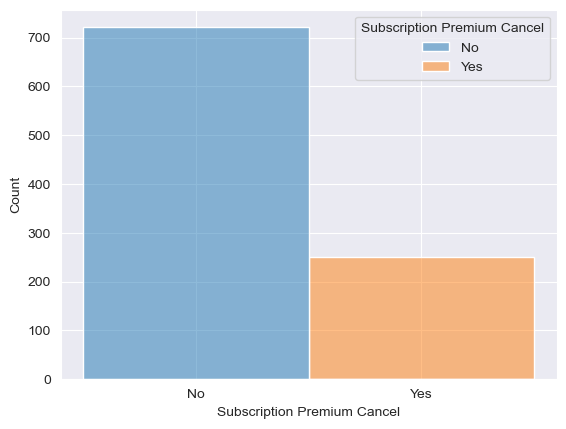

In [60]:
data = copy.deepcopy(df.drop_duplicates(subset=['userid']))

def for_hist(row) -> str:
    """
    Return labels for histogram

    :param row: Row to process
    :return: Label, 'Yes' or 'No'
    """

    return 'Yes' if row['Subscription Premium Cancel'] else 'No'

data['Subscription Premium Cancel'] = data.apply(for_hist, axis=1)
sns.histplot(data=data, x='Subscription Premium Cancel', hue='Subscription Premium Cancel')
plt.show()

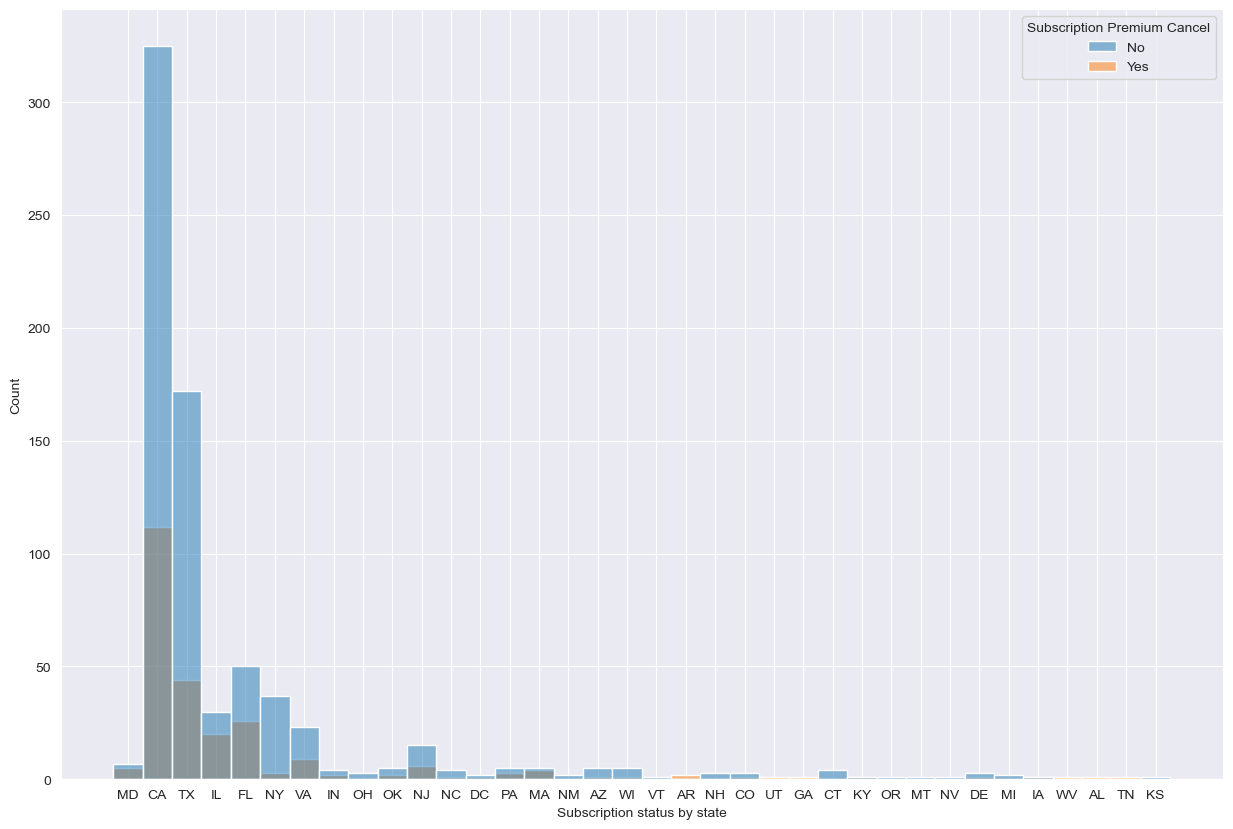

In [61]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=data, x='user_state', hue='Subscription Premium Cancel')
ax.set(xlabel='Subscription status by state')
plt.show()

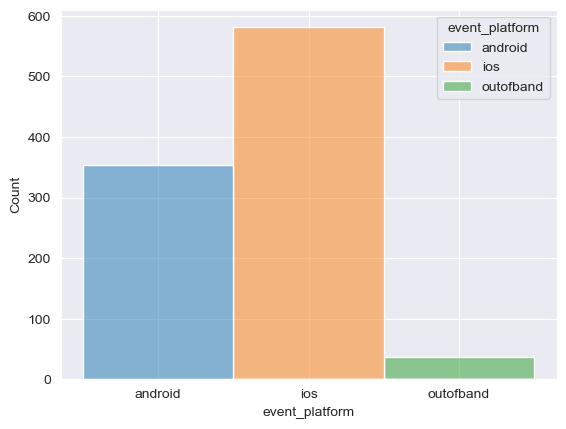

In [62]:
sns.histplot(data=data, x='event_platform', hue='event_platform')
plt.show()

In [63]:
df_static_data = create_df('csv//static_data.csv')

C:\Users\Alvareaux\AppData\Local\Temp\ipykernel_70096\410772287.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_plot = sns.heatmap(df_static_data.corr(), cmap='RdYlBu', annot=True)


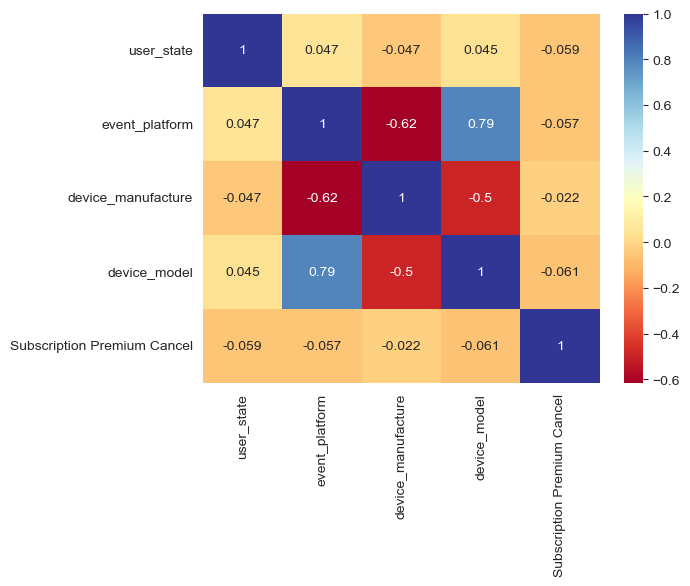

In [64]:
data_plot = sns.heatmap(df_static_data.corr(), cmap='RdYlBu', annot=True)
plt.show()

Немає ніякої кореляції із використаною платформою чи девайсом. Зі штатом прямої кореляції також немає - можливо пов'язано із великою кількістью даних по Каліфорнії та Техасу у вибірці. Відсоток відписавшихся в різних штатах є різним.

In [65]:
df_state = create_df('csv//feature_per_state.csv')

In [66]:
df_state[['user_state', 'cancel_percentage']].transpose()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
user_state,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,OK,OR,PA,TN,TX,UT,VA,VT,WI,WV
cancel_percentage,1.0,1.0,0.042453,0.377438,0.55,0.0,0.705882,0.058824,0.301661,1.0,...,0.376471,0.0,0.387597,1.0,0.195059,1.0,0.420712,0.0,0.056338,1.0


In [67]:
df_date = create_df('csv//event_and_date_data.csv')

In [68]:
df_error_rate = create_df('csv//error_data.csv')
df_error_rate = df_error_rate.iloc[: , :-5]

Є невелика кореляція з невдалими спробами додати оплату. 

C:\Users\Alvareaux\AppData\Local\Temp\ipykernel_70096\409433536.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_plot = sns.heatmap(df_error_rate.corr(), cmap='RdYlBu', annot=True)


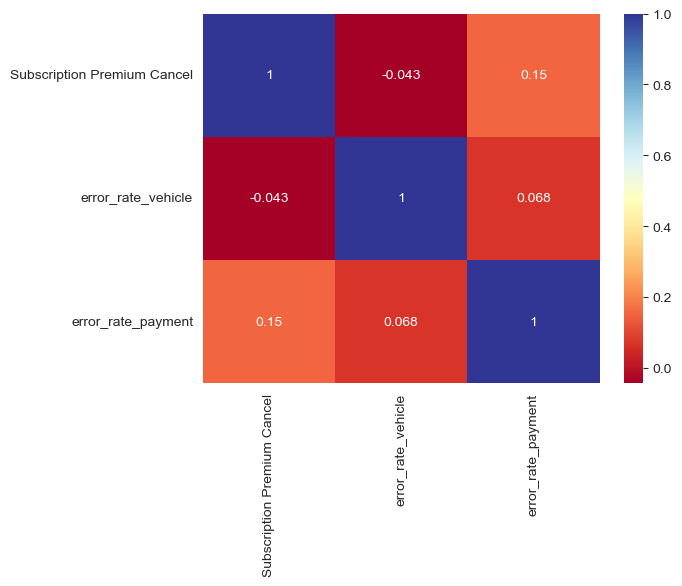

In [69]:
data_plot = sns.heatmap(df_error_rate.corr(), cmap='RdYlBu', annot=True)
plt.show()

Існує невеличка кореляція відміни підписки з виниканням події 'Add Payment Method Failed', яка є частиною метрики error_rate_payment. У свою чергу, error_rate_vehicle відповідає за кількість помилок, які виникають під час операцій з додаванням автівок і не корелює з відміною підписки.

In [70]:
subscription_check = create_df('csv//subscription_check.csv')

Всі підписки оформлювалися лише на рік.

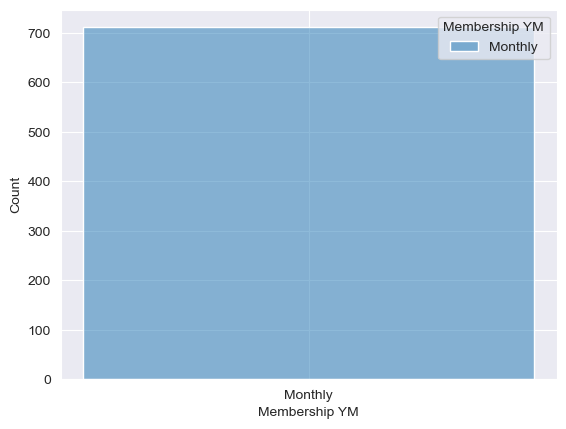

In [71]:
data = copy.deepcopy(subscription_check.drop_duplicates(subset = ['userid']))

def for_hist(row):
    """
    Return labels for histogram

    :param row: Row to process
    :return: Label, 'Yearly' or 'Monthly'
    """

    return 'Yearly' if row['Membership YM'] else 'Monthly'

data['Membership YM'] = data.apply(for_hist, axis=1)
sns.histplot(data=data, x='Membership YM', hue='Membership YM')
plt.show()

In [72]:
renew_check = create_df('csv//renew_check.csv')

Більшість підписок подовжувалися на місяць.

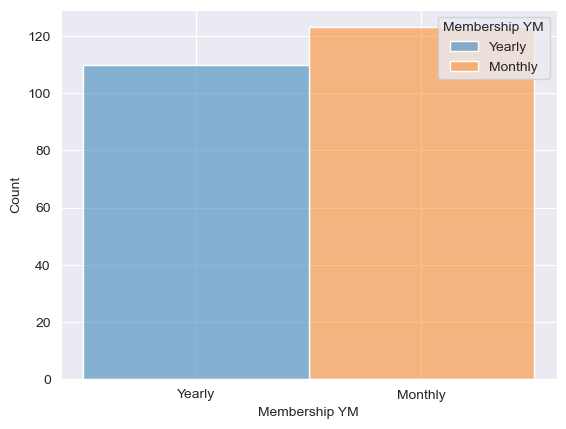

In [73]:
data = copy.deepcopy(renew_check.drop_duplicates(subset=['userid']))

data['Membership YM'] = data.apply(for_hist, axis=1)
sns.histplot(data=data, x='Membership YM', hue='Membership YM')
plt.show()

In [74]:
def event_occurred_per_user(row) -> bool:
    """
    Return True if userid from row in event list

    :param row: Row to process
    :return: True or False
    """

    return row['userid'] in event_list

In [75]:
subscription_check = subscription_check.drop(['Membership YM'], axis=1)

events = ['Chat Conversation Opened', 'Chat Conversation Started', 'Transaction Refund']
for i in events:
    event = i
    df_temp = df[df['event_name'] == event]
    event_list = df_temp['userid'].unique()
    renew_check[event] = renew_check.apply(event_occurred_per_user, axis=1)
    subscription_check[event] = subscription_check.apply(event_occurred_per_user, axis=1)

Матриці кореляцій подій та їх різниці у часі від припинення підписки із подією припинення підписки.

C:\Users\Alvareaux\AppData\Local\Temp\ipykernel_70096\4167156818.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_plot = sns.heatmap(subscription_check.corr(), cmap='RdYlBu', annot=True)


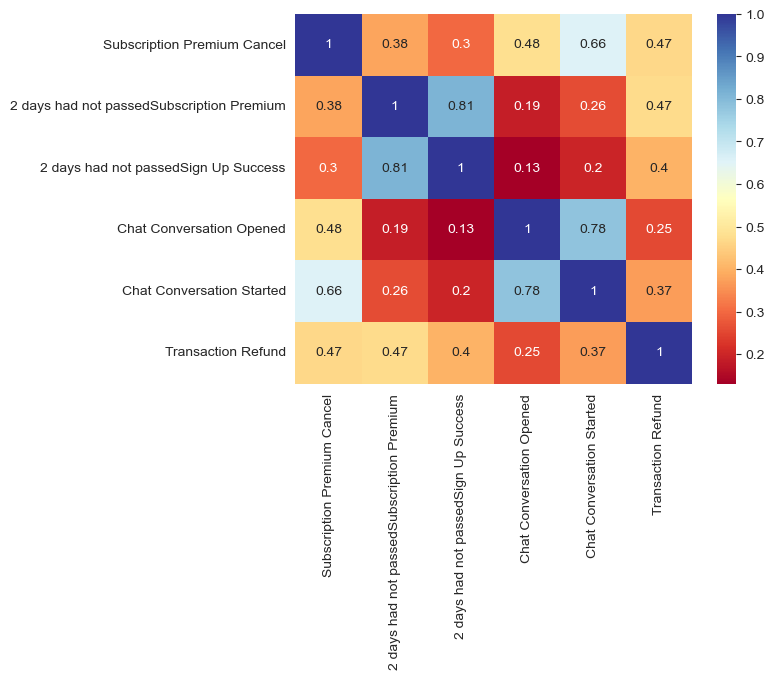

In [76]:
data_plot = sns.heatmap(subscription_check.corr(), cmap='RdYlBu', annot=True)
plt.show()

C:\Users\Alvareaux\AppData\Local\Temp\ipykernel_70096\3373579381.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_plot = sns.heatmap(renew_check.corr(), cmap='RdYlBu', annot=True)


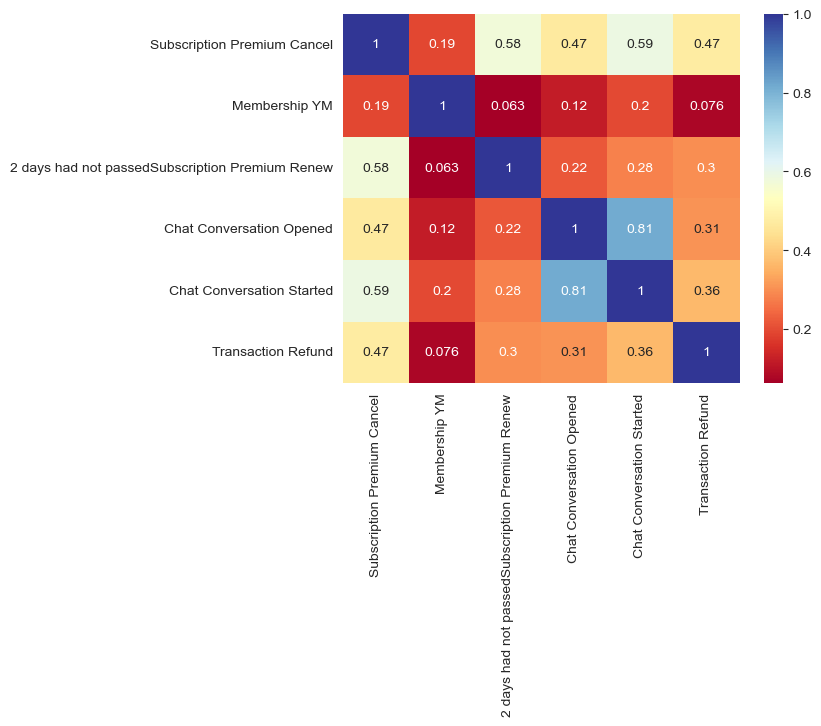

In [77]:
data_plot = sns.heatmap(renew_check.corr(), cmap='RdYlBu', annot=True)
plt.show()

Є невелика кореляція із типом подовженої підписки. Велика кореляція із зверненням в підтримку та із фактом подовження підписки за останні два дні.

In [78]:
datetime_df = create_df('csv//event_and_date_data.csv')

In [79]:
df_date_hist = datetime_df[datetime_df['Subscription Premium Cancel']==1]

In [80]:
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def weekday(row) -> str:
    """
    Get day of the week from row

    :param row: Row to process
    :return: Week day
    """

    return week_days[row['day_week']]

In [81]:
df_date_hist['week_day'] = df_date_hist.apply(weekday, axis=1)

C:\Users\Alvareaux\AppData\Local\Temp\ipykernel_70096\1483190309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date_hist['week_day'] = df_date_hist.apply(weekday, axis=1)


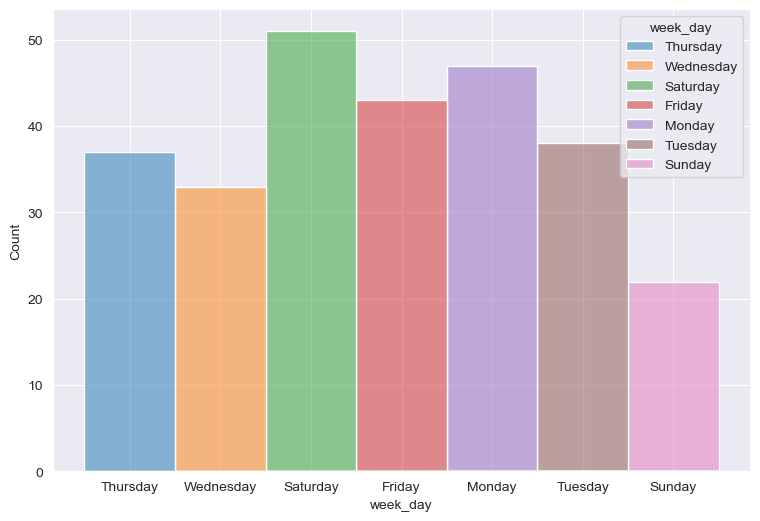

In [84]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(data=df_date_hist, x='week_day', hue='week_day')
plt.show()

Найбільше відписок було у суботу та понеділок, але набір даних замалий для будь-яких висновків на даній основі.

Висновок: найменш корельованими показниками є девайс, його виробник та події які виконувались всіми користувачами, найбільш корельованими - наявність замовлень та звернення до підтримки. Більшість відписок трапляється або після автоматичного подовження підписки (яке зазвичай є подовженням на рік) або одразу після оформлення підписки. Також дещо впливає помилка при додаванні способу оплати.

Спробуємо перевірити більшість з цих характеристик на важливість за допомогою лісу рішень та лінійної регресії.

In [86]:
df_ultimate = create_df('csv//df_all.csv')
df_ultimate = df_ultimate.drop([
    'userid','event_name', 'event_attributes', 'event_created_date',
    'last date Subscription Premium Cancel', 'last date Subscription Premium Renew',
    'last date Subscription Premium' , 'last date Order'
], axis=1)

In [87]:
def j_max(feat, j) -> list:
    """
    Returns indices of j max values

    :param feat: Input data
    :param j: Max values count
    :return: Result list
    """

    rows = feat.shape[0]
    indices = [
        (e // rows, e - (e // rows * rows))
        for e in  feat.flatten().argsort()[::-1][:j]
    ]

    return indices


In [88]:
def j_min(feat, j) -> list:
    """
    Returns indices of j min values

    :param feat: Input data
    :param j: Min values count
    :return: Result list
    """

    rows = feat.shape[0]
    indices = [
        (e // rows, e - (e // rows * rows))
        for e in  feat.flatten().argsort()[:j]
    ]

    return indices


In [89]:
df_ultimate.columns

Index(['user_state', 'event_platform', 'device_manufacture', 'device_model',
       'Subscription Premium Cancel', 'Add Payment Method Success',
       'Subscription Premium', 'Account History Transaction Details',
       'Add Vehicle Success', 'Subscription Premium Renew', 'Sign Up Success',
       'Order', 'Chat Conversation Opened', 'Add Vehicle Break',
       'Chat Conversation Started', 'Email Confirmation Success',
       'Add Payment Method Failed', 'Account Setup Skip', 'Calculator View',
       'Wallet Opened', 'Account Setup Profile Skip', 'Sign Out',
       'Transaction Refund', 'Calculator Used', 'Add Vehicle Failed',
       'Sign Up Error', 'Reset Password Set', 'Membership Ren',
       '2 days had not passedSubscription Premium Renew', 'Membership Sub',
       '2 days had not passedSubscription Premium', 'delta monthsOrder'],
      dtype='object')

In [90]:
x = copy.deepcopy(df_ultimate.drop(['Subscription Premium Cancel'], axis=1))

In [91]:
y = copy.deepcopy(df_ultimate['Subscription Premium Cancel'])

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Регресія:

In [94]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(x, y)
features = regression.coef_

indices = j_max(features, 5)
for i in indices:
    print(f'{x.columns[i[1]]}: {str(features[i[1]])}')

Chat Conversation Started: 0.44027537357031893
2 days had not passedSubscription Premium Renew: 0.4067842394953324
Subscription Premium Renew: 0.324438347780498
Transaction Refund: 0.22003240152991063
2 days had not passedSubscription Premium: 0.17996629533847977


In [96]:
indices = j_min(features, 5)
for i in indices:
    print(f'{x.columns[i[1]]}: {str(features[i[1]])}')

delta monthsOrder: -0.2549777386704436
Add Vehicle Success: -0.10267256297466948
Calculator View: -0.0905519100549328
Chat Conversation Opened: -0.08371569101605539
Add Payment Method Success: -0.05826206660894733


Ліс рішень:

In [98]:
forest = RandomForestClassifier()
param_grid = {
    'n_estimators': [1, 2, 5, 10],
    'max_depth': [2, 8, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [100]:
grid = GridSearchCV(forest, param_grid).fit(x, y)

print(grid.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 10}
{'max_depth': 8, 'min_samples_leaf': 4, 'n_estimators': 10}


In [101]:
forest = RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=10)
forest.fit(x, y)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=10)

In [102]:
for i in range(len(x.columns)):
    print(f'{x.columns[i]}: {str(forest.feature_importances_[i])}')

user_state: 0.01472219216271383
event_platform: 0.007402385710701051
device_manufacture: 0.0073042213065897645
device_model: 0.030001631835582937
Add Payment Method Success: 0.007480953077367673
Subscription Premium: 0.00950104151782064
Account History Transaction Details: 0.00879071025561388
Add Vehicle Success: 0.006897761633536468
Subscription Premium Renew: 0.010708240751662698
Sign Up Success: 0.0
Order: 0.028322385774831704
Chat Conversation Opened: 0.14266453209063693
Add Vehicle Break: 0.00385498025982961
Chat Conversation Started: 0.13712742761111438
Email Confirmation Success: 0.0035143634872050154
Add Payment Method Failed: 0.006086523206277391
Account Setup Skip: 0.0
Calculator View: 0.005325259806861296
Wallet Opened: 0.029811235332478855
Account Setup Profile Skip: 0.004774164739491612
Sign Out: 0.0038295234247176842
Transaction Refund: 0.02993956817226085
Calculator Used: 0.00011985370828717856
Add Vehicle Failed: 0.0
Sign Up Error: 0.0
Reset Password Set: 0.0
Membership

In [106]:
indices = j_max(forest.feature_importances_, 15)
for i in indices:
    print(f'{x.columns[i[1]]}: {str(forest.feature_importances_[i[1]])}')

delta monthsOrder: 0.438475896392389
Chat Conversation Opened: 0.14266453209063693
Chat Conversation Started: 0.13712742761111438
device_model: 0.030001631835582937
Transaction Refund: 0.02993956817226085
Wallet Opened: 0.029811235332478855
Order: 0.028322385774831704
2 days had not passedSubscription Premium Renew: 0.024525361805049703
2 days had not passedSubscription Premium: 0.01700744262301849
Membership Sub: 0.015012600058163086
user_state: 0.01472219216271383
Subscription Premium Renew: 0.010708240751662698
Subscription Premium: 0.00950104151782064
Account History Transaction Details: 0.00879071025561388
Add Payment Method Success: 0.007480953077367673


In [107]:
indices = j_min(forest.feature_importances_, 15)
for i in indices:
    print(f'{x.columns[i[1]]}: {str(forest.feature_importances_[i[1]])}')

Sign Up Success: 0.0
Account Setup Skip: 0.0
Add Vehicle Failed: 0.0
Sign Up Error: 0.0
Reset Password Set: 0.0
Calculator Used: 0.00011985370828717856
Email Confirmation Success: 0.0035143634872050154
Sign Out: 0.0038295234247176842
Add Vehicle Break: 0.00385498025982961
Account Setup Profile Skip: 0.004774164739491612
Calculator View: 0.005325259806861296
Add Payment Method Failed: 0.006086523206277391
Membership Ren: 0.006799743255798416
Add Vehicle Success: 0.006897761633536468
device_manufacture: 0.0073042213065897645
